### 8. Πλήρης Συγκριτική Ανάλυση (Χρήση Cache)
Ανάλυση όλων των αποτελεσμάτων χρησιμοποιώντας το υπάρχον Excel και JSON cache.
**ΧΩΡΙΣ νέα API calls!**

In [ ]:
# Required imports and setup
import pandas as pd
import json
from math import radians, cos, sin, asin, sqrt

# Prostheti libraries - prosthetes vivliothikes
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ACCURACY_SCORES - Accuracy scoring system
ACCURACY_SCORES = {
    'ROOFTOP': 4,
    'RANGE_INTERPOLATED': 3,
    'GEOMETRIC_CENTER': 2,
    'APPROXIMATE': 1
}

# Configuration - Rythmiseis
INPUT_EXCEL = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison.xlsx"
CACHE_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_cache.json"
OUTPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx"
OUTPUT_PLOT = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_analysis.png"

def haversine_distance(lat1, lon1, lat2, lon2):
   
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    
    # Convert to meters
    return km * 1000

print("Basika imports kai functions fortothikan!")
print("PLIRIS SIGKRITIKI ANALYSI GEOCODING METHODS")
print("To notebook einai etoimo gia ektelesi!")

Basika imports kai functions fortothikan!
To notebook einai etoimo gia ektelesi!


In [2]:
def get_cached_result(cache, address):
    # Anakta apotelesmata apo cache - retrieves results from cache
    if address in cache:
        result = cache[address]
        # Fix: Check if result is None (failed geocoding)
        if result is None:
            return None
        return {
            'lat': result.get('lat'),
            'lng': result.get('lng'),
            'accuracy': result.get('accuracy')
        }
    return None

def reconstruct_all_runs(row, cache):
    # Anakataskevazi ola ta runs apo to cache - reconstructs all runs from cache
    address = row['gasStationAddress']
    county = row['countyName']
    municipality = row['municipalityName']
    gt_lat = row['gasStationLat']
    gt_lng = row['gasStationLong']
    
    results = {}
    
    # Run 1: Address only - mono diefthinsi
    query1 = address
    result1 = get_cached_result(cache, query1)
    if result1 and result1['lat'] is not None:
        distance1 = haversine_distance(gt_lat, gt_lng, result1['lat'], result1['lng'])
        score1 = ACCURACY_SCORES.get(result1['accuracy'], 0)
        results['run1'] = {**result1, 'distance': distance1, 'score': score1}
    else:
        results['run1'] = None
    
    # Run 2: Address + County - diefthinsi + nomos
    query2 = f"{address}, {county}"
    result2 = get_cached_result(cache, query2)
    if result2 and result2['lat'] is not None:
        distance2 = haversine_distance(gt_lat, gt_lng, result2['lat'], result2['lng'])
        score2 = ACCURACY_SCORES.get(result2['accuracy'], 0)
        results['run2'] = {**result2, 'distance': distance2, 'score': score2}
    else:
        results['run2'] = None
    
    # Run 3: Address + Municipality + County - diefthinsi + dimos + nomos
    query3 = f"{address}, {municipality}, {county}"
    result3 = get_cached_result(cache, query3)
    if result3 and result3['lat'] is not None:
        distance3 = haversine_distance(gt_lat, gt_lng, result3['lat'], result3['lng'])
        score3 = ACCURACY_SCORES.get(result3['accuracy'], 0)
        results['run3'] = {**result3, 'distance': distance3, 'score': score3}
    else:
        results['run3'] = None
    
    # Best method - kalyteri methodos
    valid_methods = {k: v for k, v in results.items() if v is not None}
    if valid_methods:
        best_method = min(valid_methods.keys(), key=lambda k: valid_methods[k]['distance'])
        results['best'] = {**valid_methods[best_method], 'best_method': best_method}
    else:
        results['best'] = None
    
    return results

In [ ]:
def calculate_method_stats(df, method):
    # Ypologizi statistika gia mia methodo - calculates statistics for one method
    distance_col = f'{method}_distance'
    score_col = f'{method}_score'
    accuracy_col = f'{method}_accuracy'
    
    valid_distances = df[distance_col].dropna()
    
    # Fix: Calculate percentages correctly - diorthosi ypologismoy pososto
    total_stations = len(df)
    successful_count = (df[accuracy_col].notna() & (df[accuracy_col] != 'FAILED')).sum()
    
    return {
        'Method': method.upper(),
        'Total_Stations': total_stations,
        'Successful': successful_count,
        'Failed': total_stations - successful_count,
        'SUM_distances_m': valid_distances.sum() if len(valid_distances) > 0 else None,
        'MEAN_distance_m': valid_distances.mean() if len(valid_distances) > 0 else None,
        'MEDIAN_distance_m': valid_distances.median() if len(valid_distances) > 0 else None,
        'MIN_distance_m': valid_distances.min() if len(valid_distances) > 0 else None,
        'MAX_distance_m': valid_distances.max() if len(valid_distances) > 0 else None,
        'SUM_scores': df[score_col].sum(),
        'MEAN_score': df[score_col].mean(),
        'PCT_ROOFTOP': (df[accuracy_col] == 'ROOFTOP').sum() / total_stations * 100,
        'PCT_RANGE_INTERPOLATED': (df[accuracy_col] == 'RANGE_INTERPOLATED').sum() / total_stations * 100,
        'PCT_GEOMETRIC_CENTER': (df[accuracy_col] == 'GEOMETRIC_CENTER').sum() / total_stations * 100,
        'PCT_APPROXIMATE': (df[accuracy_col] == 'APPROXIMATE').sum() / total_stations * 100,
        'PCT_Success': successful_count / total_stations * 100
    }

In [7]:
# 1. Load data - fortosi dedomenon
print("Fortosi dedomenon...")
df_existing = pd.read_excel(INPUT_EXCEL)
print(f"   Excel: {len(df_existing)} stathmoi")

if not Path(CACHE_FILE).exists():
    print(f"\nLATHOS: Den vrethike to cache file: {CACHE_FILE}")
    print("   Parakalo allakse to CACHE_FILE path sto configuration section!")
else:
    with open(CACHE_FILE, 'r', encoding='utf-8') as f:
        cache = json.load(f)
    print(f"   Cache: {len(cache)} cached results")

Fortosi dedomenon...
   Excel: 1026 stathmoi
   Cache: 3064 cached results


In [ ]:
# 2. Reconstruct all runs - anakataskevi olon ton runs
print("\nAnakataskevi olon ton runs apo cache...")
all_results = []
for idx, row in tqdm(df_existing.iterrows(), total=len(df_existing), desc="Processing"):
        results = reconstruct_all_runs(row, cache)
        all_results.append({'row_data': row, 'results': results})


Anakataskevi olon ton runs apo cache...


Processing: 100%|██████████| 1026/1026 [00:00<00:00, 45254.66it/s]


In [ ]:
# 3. Create full Excel data - dimiourgeia pliroys dataset
print("\nDimiourgeia pliroys dataset...")
excel_data = []
    
for item in all_results:
        row = item['row_data']
        results = item['results']
        
        row_data = {
            'gasStationID': row['gasStationID'],
            'gasStationAddress': row['gasStationAddress'],
            'gasStationLat': row['gasStationLat'],
            'gasStationLong': row['gasStationLong'],
            'ddName': row['ddName'],
            'municipalityName': row['municipalityName'],
            'countyName': row['countyName'],
        }
        
        # Add all runs - prosthiki olon ton runs
        for run_name in ['run1', 'run2', 'run3']:
            if results.get(run_name):
                row_data.update({
                    f'{run_name}_lat': results[run_name]['lat'],
                    f'{run_name}_lng': results[run_name]['lng'],
                    f'{run_name}_accuracy': results[run_name]['accuracy'],
                    f'{run_name}_score': results[run_name]['score'],
                    f'{run_name}_distance': results[run_name]['distance']
                })
            else:
                row_data.update({
                    f'{run_name}_lat': None,
                    f'{run_name}_lng': None,
                    f'{run_name}_accuracy': 'FAILED',
                    f'{run_name}_score': 0,
                    f'{run_name}_distance': None
                })
        
        # Add best - prosthiki kalyteroy
        if results.get('best'):
            row_data.update({
                'best_method': results['best']['best_method'],
                'best_lat': results['best']['lat'],
                'best_lng': results['best']['lng'],
                'best_accuracy': results['best']['accuracy'],
                'best_score': results['best']['score'],
                'best_distance': results['best']['distance']
            })
        else:
            row_data.update({
                'best_method': 'ALL_FAILED',
                'best_lat': None,
                'best_lng': None,
                'best_accuracy': 'FAILED',
                'best_score': 0,
                'best_distance': None
            })
        
        excel_data.append(row_data)
    
    excel_df = pd.DataFrame(excel_data)


Dimiourgeia pliroys dataset...


In [ ]:
 # 4. Calculate summary statistics - ypologismos statistikon
print("\n ypologismos statistics...")
summary_data = []
for method in ['run1', 'run2', 'run3', 'best']:
        summary_data.append(calculate_method_stats(excel_df, method))
        summary_df = pd.DataFrame(summary_data)
    
# 5. Save to Excel - apothikefsi se Excel
print("\nApothikefsi se Excel...")
with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl') as writer:
        excel_df.to_excel(writer, sheet_name='Raw Results', index=False)
        summary_df.to_excel(writer, sheet_name='Summary Statistics', index=False)
        print(f"   Saved: {OUTPUT_FILE}")


Ypologismos statistics...

Apothikefsi se Excel...
   Saved: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL_1.xlsx


In [ ]:
# 6. Display summary - emfanisi perilipsis
print("\n")
print("SUMMARY STATISTICS")
print("="*70)
print(summary_df[['Method', 'Successful', 'Failed', 'MEAN_distance_m', 
                      'PCT_ROOFTOP', 'PCT_Success']].to_string(index=False))


SUMMARY STATISTICS
Method  Successful  Failed  MEAN_distance_m  PCT_ROOFTOP  PCT_Success
  RUN1        1001      25     27683.037066     2.241715    97.563353
  RUN2        1016      10     14870.496987     2.729045    99.025341
  RUN3        1023       3     14633.270598     4.580897    99.707602
  BEST        1023       3      6205.639304     3.313840    99.707602



Dimiourgeia visualizations...


/var/folders/p0/xzz6s78d7qz16fk988wn1p8h0000gn/T/ipykernel_52208/3080095337.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,0].boxplot(distance_data, labels=methods, patch_artist=True, widths=0.6)


   Saved: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_analysis.png


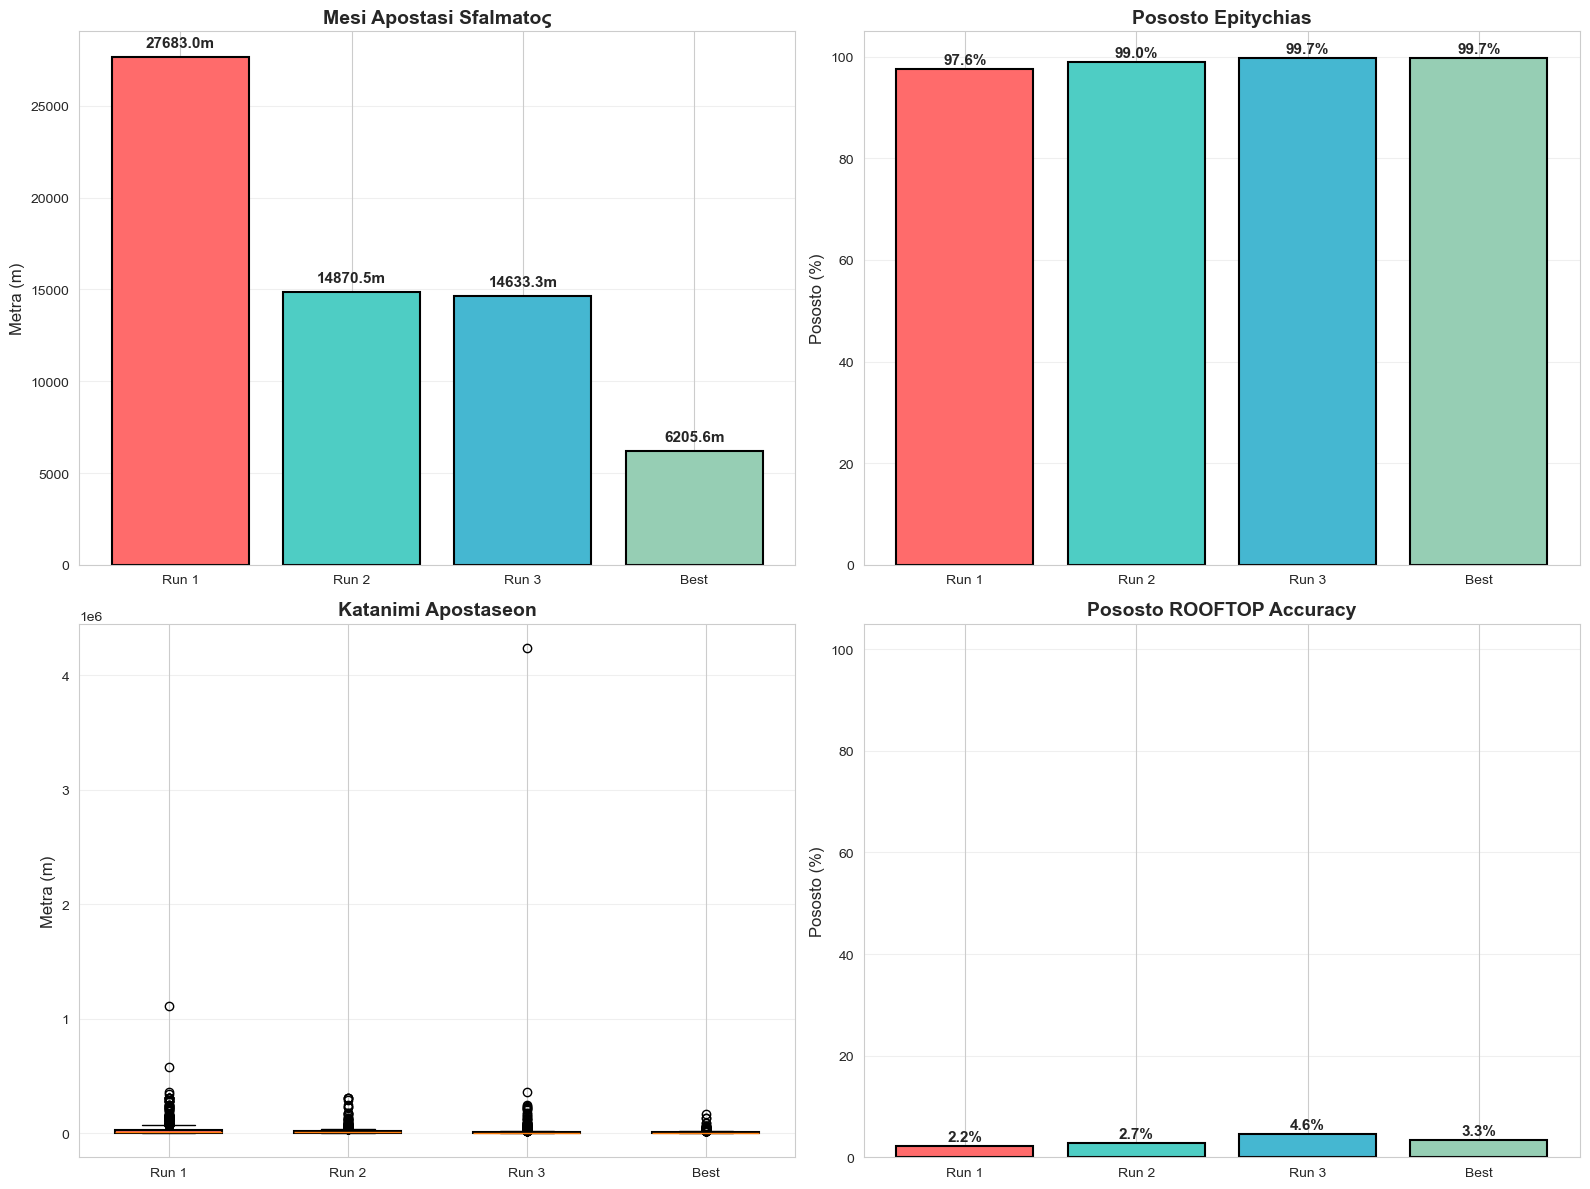

In [ ]:
# 7. Visualizations - grafimata
print("\nDimiourgeia visualizations...")
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
methods = ['Run 1', 'Run 2', 'Run 3', 'Best']
    
# 1. Mean Distance - mesi apostasi
mean_distances = [summary_df.iloc[i]['MEAN_distance_m'] for i in range(4)]
axes[0,0].bar(methods, mean_distances, color=colors, edgecolor='black', linewidth=1.5)
axes[0,0].set_title('Mesi Apostasi Sfalmatος', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Metra (m)', fontsize=12)
axes[0,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mean_distances):
        axes[0,0].text(i, v + max(mean_distances)*0.02, f'{v:.1f}m', 
                       ha='center', fontweight='bold', fontsize=11)
    
# 2. Success Rate - pososto epitychias
success_rates = [summary_df.iloc[i]['PCT_Success'] for i in range(4)]
axes[0,1].bar(methods, success_rates, color=colors, edgecolor='black', linewidth=1.5)
axes[0,1].set_title('Pososto Epitychias', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Pososto (%)', fontsize=12)
axes[0,1].set_ylim(0, 105)
axes[0,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(success_rates):
        axes[0,1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=11)
    
# 3. Boxplot - katanimi apostaseon
distance_data = [excel_df[f'{m}_distance'].dropna() for m in ['run1', 'run2', 'run3', 'best']]
bp = axes[1,0].boxplot(distance_data, labels=methods, patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)
    axes[1,0].set_title('Katanimi Apostaseon', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Metra (m)', fontsize=12)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # 4. ROOFTOP % - pososto ROOFTOP
    rooftop_pct = [summary_df.iloc[i]['PCT_ROOFTOP'] for i in range(4)]
    axes[1,1].bar(methods, rooftop_pct, color=colors, edgecolor='black', linewidth=1.5)
    axes[1,1].set_title('Pososto ROOFTOP Accuracy', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Pososto (%)', fontsize=12)
    axes[1,1].set_ylim(0, 105)
    axes[1,1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(rooftop_pct):
        axes[1,1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=11)
        
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT, dpi=300, bbox_inches='tight')
    print(f"   Saved: {OUTPUT_PLOT}")
    plt.show() 

In [ ]:
    # 8. Final conclusions - telika symberasmata
print("\n")
print("TELIKA SYMBERASMATA")
print("="*70)
    
run1_sum = summary_df.iloc[0]['SUM_distances_m']
best_sum = summary_df.iloc[3]['SUM_distances_m']
improvement = ((run1_sum - best_sum) / run1_sum) * 100
    
best_method_row = summary_df.iloc[3]
    
print(f"\nKALYTERI METHODOS: {best_method_row['Method']}")
print(f"   • Mesi apostasi: {best_method_row['MEAN_distance_m']:.1f}m")
print(f"   • Median apostasi: {best_method_row['MEDIAN_distance_m']:.1f}m")
print(f"   • Pososto epitychias: {best_method_row['PCT_Success']:.1f}%")
print(f"   • Pososto ROOFTOP: {best_method_row['PCT_ROOFTOP']:.1f}%")
    
print(f"\nVeltiosi Best vs Run1:")
print(f"   • Meiosi synolikoy sfalmatος: {improvement:.1f}%")
print(f"   • SUM(distances): {run1_sum:,.0f}m → {best_sum:,.0f}m")
    
print(f"\nParatiriseis:")
print(f"   • Akoma kai me best method, mesi apostasi = {best_method_row['MEAN_distance_m']:.1f}m")
print(f"   • Ayto dikaiologei tin anagki gia computer vision validation!")
print(f"   • I stratigiki 'pick best of 3' veltioyei tin akriveia kata {improvement:.1f}%")
    
print("\n" + "="*70)
print("OLOKLIROTHIKE I ANALYSI")
print("="*70 + "\n")


TELIKA SYMBERASMATA

KALYTERI METHODOS: BEST
   • Mesi apostasi: 6205.6m
   • Median apostasi: 2896.1m
   • Pososto epitychias: 99.7%
   • Pososto ROOFTOP: 3.3%

Veltiosi Best vs Run1:
   • Meiosi synolikoy sfalmatος: 77.1%
   • SUM(distances): 27710720m → 6348369m

Paratiriseis:
   • Akoma kai me best method, mesi apostasi = 6206m
   • Ayto dikaiologei tin anagki gia computer vision validation!
   • I stratigiki 'pick best of 3' veltioyei tin akriveia kata 77.1%

OLOKLIROTHIKE I ANALYSI



In [ ]:
# 9. Failed geocoding analysis - analysi apotychion geocoding
print("\n")
print("ANALYSI APOTYCHION GEOCODING")
print("\n")

# Find stations that failed in all runs - vratire stathmoys poy apetychan se ola ta runs
failed_all = excel_df[
        (excel_df['run1_accuracy'] == 'FAILED') & 
        (excel_df['run2_accuracy'] == 'FAILED') & 
        (excel_df['run3_accuracy'] == 'FAILED')
    ]
    
# Find stations that failed in each individual run - stathmoi poy apetychan se kathe run
failed_run1 = excel_df[excel_df['run1_accuracy'] == 'FAILED']
failed_run2 = excel_df[excel_df['run2_accuracy'] == 'FAILED']
failed_run3 = excel_df[excel_df['run3_accuracy'] == 'FAILED']
    
print(f"\nSYNOLIKA APOTYCHIA:")
print(f"   • Failed se ola ta runs (ALL_FAILED): {len(failed_all)} stathmoi")
print(f"   • Failed mono sto Run1: {len(failed_run1)} stathmoi")
print(f"   • Failed mono sto Run2: {len(failed_run2)} stathmoi") 
print(f"   • Failed mono sto Run3: {len(failed_run3)} stathmoi")
    
if len(failed_all) > 0:
        print(f"\n" + "-"*50)
        print(f"STATHMOI POY APETYCHAN SE OLA TA RUNS ({len(failed_all)} stathmoi):")
        print("-"*50)
        
        for idx, row in failed_all.iterrows():
            print(f"ID: {row['gasStationID']}")
            print(f"   Diefthinsi: {row['gasStationAddress']}")
            print(f"   Dimos: {row['municipalityName']}")
            print(f"   Nomos: {row['countyName']}")
            print(f"   Ground Truth: ({row['gasStationLat']:.6f}, {row['gasStationLong']:.6f})")
            print()
else:
        print(f"\n KALYTERA NEA: Den yparxoyn stathmoi poy na apetychan se ola ta runs!")
    
# Analysis by method - analysi ana methodo
print(f"\n")
print(f"APOTYCHIA ANA METHODO:")
print("-"*50)
print(f"Run1 (Address only): {len(failed_run1)}/{len(excel_df)} = {len(failed_run1)/len(excel_df)*100:.1f}% apotychia")
print(f"Run2 (Address + County): {len(failed_run2)}/{len(excel_df)} = {len(failed_run2)/len(excel_df)*100:.1f}% apotychia")
print(f"Run3 (Address + Municipality + County): {len(failed_run3)}/{len(excel_df)} = {len(failed_run3)/len(excel_df)*100:.1f}% apotychia")
    
# Improvement analysis - analysi veltiosis
improvement_run2 = len(failed_run1) - len(failed_run2)
improvement_run3 = len(failed_run1) - len(failed_run3)
    
print(f"\nVELTIOSI:")
print(f"   • Run2 vs Run1: {improvement_run2:+d} stathmoi ({improvement_run2/len(excel_df)*100:+.1f}%)")
print(f"   • Run3 vs Run1: {improvement_run3:+d} stathmoi ({improvement_run3/len(excel_df)*100:+.1f}%)")
    
print("\n")


ANALYSI APOTYCHION GEOCODING

SYNOLIKA APOTYCHIA:
   • Failed se ola ta runs (ALL_FAILED): 3 stathmoi
   • Failed mono sto Run1: 25 stathmoi
   • Failed mono sto Run2: 10 stathmoi
   • Failed mono sto Run3: 3 stathmoi

--------------------------------------------------
STATHMOI POY APETYCHAN SE OLA TA RUNS (3 stathmoi):
--------------------------------------------------
ID: 12248
   Diefthinsi: 3ο χλμ ΕΟ Τρικάλων - Πύλης (δεξιά), Θέση «Γούρνες ή μμος» της κτηματικής περιφέρειας Τρικάλων, στη συνοικία Αγία Μονή
   Dimos: ΔΗΜΟΣ ΤΡΙΚΚΑΙΩΝ
   Nomos: ΤΡΙΚΑΛΩΝ
   Ground Truth: (39.533611, 21.749386)

ID: 13741
   Diefthinsi: 38ο χλμ της Εθνικής οδού Ρόδου  Λίνδου Δημοτική Ενότητα Αρχαγγέλου
   Dimos: ΔΗΜΟΣ ΑΡΧΑΓΓΕΛΟΥ
   Nomos: ΔΩΔΕΚΑΝΗΣΟΥ
   Ground Truth: (36.217100, 28.107961)

ID: 13094
   Diefthinsi: 23ο χιλ. Ε.Ο. Ιωαννίνων  Κοζάνης
   Dimos: ΔΗΜΟΣ ΕΚΑΛΗΣ
   Nomos: ΙΩΑΝΝΙΝΩΝ
   Ground Truth: (39.811439, 20.715153)


--------------------------------------------------
APOTYCHIA ANA METH

In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_excel('/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx', sheet_name='raw results')

# Calculate Circular Error metrics
distances = df['best_distance'].dropna()

thresholds = [50, 100, 200, 500, 1000, 5000]
ce_metrics = {}

print(" CIRCULAR ERROR (CE) METRICS \n")
for threshold in thresholds:    
    count = (distances <= threshold).sum()
    percentage = (count / len(distances)) * 100
    ce_metrics[f'CE{threshold}'] = {
        'count': count,
        'percentage': percentage
    }
    print(f"CE{threshold}m:  {count:4d}/{len(distances)} ({percentage:5.2f}%)")

# Create summary for thesis
ce_summary = pd.DataFrame([
    {'Metric': f'CE{t}', 
     'Threshold (m)': t, 
     'Stations': ce_metrics[f'CE{t}']['count'],
     'Percentage': f"{ce_metrics[f'CE{t}']['percentage']:.2f}%"} 
    for t in thresholds
])

print("\n SUMMARY TABLE ")
print(ce_summary.to_string(index=False))

 CIRCULAR ERROR (CE) METRICS 

CE50m:    23/1023 ( 2.25%)
CE100m:    27/1023 ( 2.64%)
CE200m:    39/1023 ( 3.81%)
CE500m:    76/1023 ( 7.43%)
CE1000m:   164/1023 (16.03%)
CE5000m:   699/1023 (68.33%)

 SUMMARY TABLE 
Metric  Threshold (m)  Stations Percentage
  CE50             50        23      2.25%
 CE100            100        27      2.64%
 CE200            200        39      3.81%
 CE500            500        76      7.43%
CE1000           1000       164     16.03%
CE5000           5000       699     68.33%


In [2]:
# Comprehensive Circular Error Analysis for ALL methods
import pandas as pd
import numpy as np

# Load data
df = pd.read_excel('/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx', sheet_name='raw results')

print("🎯 COMPREHENSIVE CIRCULAR ERROR ANALYSIS")
print("="*80)
print(f"Dataset: {len(df)} fuel stations")
print()

# Define thresholds
thresholds = [50, 100, 200, 500, 1000, 5000]
methods = ['run1', 'run2', 'run3', 'best']
method_names = ['Run1 (Address)', 'Run2 (+County)', 'Run3 (+Municipality)', 'Best Method']

# Create comprehensive CE table
ce_results = []

for i, method in enumerate(methods):
    distances = df[f'{method}_distance'].dropna()
    total_valid = len(distances)
    
    method_data = {
        'Method': method_names[i],
        'Valid_Stations': total_valid,
        'Mean_Distance_m': distances.mean(),
        'Median_Distance_m': distances.median()
    }
    
    for threshold in thresholds:
        count = (distances <= threshold).sum()
        percentage = (count / total_valid) * 100 if total_valid > 0 else 0
        method_data[f'CE{threshold}'] = f"{count}/{total_valid} ({percentage:.2f}%)"
    
    ce_results.append(method_data)

# Convert to DataFrame
ce_df = pd.DataFrame(ce_results)

# Display results
print("CIRCULAR ERROR METRICS BY METHOD")
print("-" * 80)
print(f"{'Method':<20} {'Valid':<8} {'Mean(m)':<8} {'Median(m)':<8}")
print("-" * 80)

for i, row in ce_df.iterrows():
    print(f"{row['Method']:<20} {row['Valid_Stations']:<8} {row['Mean_Distance_m']:<8.0f} {row['Median_Distance_m']:<8.0f}")

print()
print("DETAILED CE BREAKDOWN")
print("-" * 120)
print(f"{'Method':<20} {'CE50':<15} {'CE100':<15} {'CE200':<15} {'CE500':<15} {'CE1000':<15} {'CE5000':<15}")
print("-" * 120)

for i, row in ce_df.iterrows():
    print(f"{row['Method']:<20} {row['CE50']:<15} {row['CE100']:<15} {row['CE200']:<15} {row['CE500']:<15} {row['CE1000']:<15} {row['CE5000']:<15}")

print()
print("📊 KEY INSIGHTS:")
print("-" * 40)

# Calculate improvements
run1_distances = df['run1_distance'].dropna()
best_distances = df['best_distance'].dropna()

for threshold in [50, 100, 500, 1000]:
    run1_ce = (run1_distances <= threshold).sum()
    best_ce = (best_distances <= threshold).sum()
    improvement = best_ce - run1_ce
    
    print(f"CE{threshold:4d}: Run1={run1_ce:3d} → Best={best_ce:3d} (+{improvement:3d} stations, {improvement/len(run1_distances)*100:+5.2f}%)")

print()
print("🏆 BEST PERFORMING METHOD:")
best_mean = ce_df.loc[ce_df['Method'] == 'Best Method', 'Mean_Distance_m'].iloc[0]
print(f"   Best Method achieves {best_mean:.0f}m average error")
print(f"   This represents the theoretical maximum with perfect method selection")

# Save detailed results
ce_df.to_excel('/Users/geo/Desktop/fuelstation-detection-thesis/data/circular_error_analysis.xlsx', index=False)
print(f"\n💾 Detailed results saved to: circular_error_analysis.xlsx")

🎯 COMPREHENSIVE CIRCULAR ERROR ANALYSIS
Dataset: 1026 fuel stations

CIRCULAR ERROR METRICS BY METHOD
--------------------------------------------------------------------------------
Method               Valid    Mean(m)  Median(m)
--------------------------------------------------------------------------------
Run1 (Address)       1001     27683    6959    
Run2 (+County)       1016     14870    5575    
Run3 (+Municipality) 1023     14633    3589    
Best Method          1023     6206     2896    

DETAILED CE BREAKDOWN
------------------------------------------------------------------------------------------------------------------------
Method               CE50            CE100           CE200           CE500           CE1000          CE5000         
------------------------------------------------------------------------------------------------------------------------
Run1 (Address)       15/1001 (1.50%) 18/1001 (1.80%) 24/1001 (2.40%) 50/1001 (5.00%) 103/1001 (10.29%) 431/1001 (

In [3]:
# 🎯 CIRCULAR ERROR ANALYSIS - 19 CLEANING METHODS
# Analysis of all address cleaning methods from ML experiment

import pandas as pd
import numpy as np

# Load the 19-methods data
ml_file = '/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_pattern_analysis_ml/geocoding_19methods_full.xlsx'
df_ml = pd.read_excel(ml_file)

print("🔬 CIRCULAR ERROR ANALYSIS - 19 ADDRESS CLEANING METHODS")
print("="*90)
print(f"Dataset: {len(df_ml)} fuel stations")
print()

# Find all method columns (those ending with '_distance')
distance_columns = [col for col in df_ml.columns if col.endswith('_distance')]
cleaning_methods = [col.replace('_distance', '') for col in distance_columns]

print(f"Found {len(cleaning_methods)} cleaning methods:")
for i, method in enumerate(cleaning_methods, 1):
    print(f"  {i:2d}. {method}")
print()

# Define thresholds
thresholds = [50, 100, 200, 500, 1000, 5000]

# Calculate CE metrics for each method
ce_results_19 = []

for method in cleaning_methods:
    distance_col = f'{method}_distance'
    distances = df_ml[distance_col].dropna()
    total_valid = len(distances)
    
    if total_valid == 0:
        continue
    
    method_data = {
        'Method': method,
        'Valid_Stations': total_valid,
        'Failed_Stations': len(df_ml) - total_valid,
        'Success_Rate_%': (total_valid / len(df_ml)) * 100,
        'Mean_Distance_m': distances.mean(),
        'Median_Distance_m': distances.median(),
        'Std_Distance_m': distances.std()
    }
    
    # Calculate CE metrics
    for threshold in thresholds:
        count = (distances <= threshold).sum()
        percentage = (count / total_valid) * 100
        method_data[f'CE{threshold}_count'] = count
        method_data[f'CE{threshold}_pct'] = percentage
    
    ce_results_19.append(method_data)

# Convert to DataFrame and sort by mean distance
ce_df_19 = pd.DataFrame(ce_results_19)
ce_df_19_sorted = ce_df_19.sort_values('Mean_Distance_m')

print("RANKING BY MEAN DISTANCE (Best to Worst)")
print("-" * 90)
print(f"{'Rank':<4} {'Method':<25} {'Mean(m)':<8} {'CE50%':<6} {'CE100%':<7} {'CE500%':<7} {'Success%':<8}")
print("-" * 90)

for i, (_, row) in enumerate(ce_df_19_sorted.iterrows(), 1):
    print(f"{i:3d}. {row['Method']:<25} {row['Mean_Distance_m']:7.0f} {row['CE50_pct']:5.1f} {row['CE100_pct']:6.1f} {row['CE500_pct']:6.1f} {row['Success_Rate_%']:7.1f}")

print()
print("🏆 TOP 5 BEST PERFORMING METHODS:")
print("-" * 50)
top_5 = ce_df_19_sorted.head(5)
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. {row['Method']}")
    print(f"   Mean Distance: {row['Mean_Distance_m']:.0f}m")
    print(f"   CE50:  {row['CE50_count']:3d}/{row['Valid_Stations']} ({row['CE50_pct']:5.1f}%)")
    print(f"   CE100: {row['CE100_count']:3d}/{row['Valid_Stations']} ({row['CE100_pct']:5.1f}%)")
    print(f"   CE500: {row['CE500_count']:3d}/{row['Valid_Stations']} ({row['CE500_pct']:5.1f}%)")
    print()

print("🔍 DETAILED CE BREAKDOWN - TOP 10 METHODS:")
print("-" * 120)
print(f"{'Method':<25} {'CE50':<12} {'CE100':<12} {'CE200':<12} {'CE500':<12} {'CE1000':<12} {'CE5000':<12}")
print("-" * 120)

top_10 = ce_df_19_sorted.head(10)
for _, row in top_10.iterrows():
    ce50_str = f"{row['CE50_count']}/{row['Valid_Stations']} ({row['CE50_pct']:.1f}%)"
    ce100_str = f"{row['CE100_count']}/{row['Valid_Stations']} ({row['CE100_pct']:.1f}%)"
    ce200_str = f"{row['CE200_count']}/{row['Valid_Stations']} ({row['CE200_pct']:.1f}%)"
    ce500_str = f"{row['CE500_count']}/{row['Valid_Stations']} ({row['CE500_pct']:.1f}%)"
    ce1000_str = f"{row['CE1000_count']}/{row['Valid_Stations']} ({row['CE1000_pct']:.1f}%)"
    ce5000_str = f"{row['CE5000_count']}/{row['Valid_Stations']} ({row['CE5000_pct']:.1f}%)"
    
    print(f"{row['Method']:<25} {ce50_str:<12} {ce100_str:<12} {ce200_str:<12} {ce500_str:<12} {ce1000_str:<12} {ce5000_str:<12}")

print()
print("📊 KEY INSIGHTS:")
print("-" * 40)

# Compare best vs original
best_method = ce_df_19_sorted.iloc[0]
original_method = ce_df_19[ce_df_19['Method'].str.contains('original|v1')].iloc[0] if any(ce_df_19['Method'].str.contains('original|v1')) else None

print(f"Best Method: {best_method['Method']}")
print(f"  - Mean Distance: {best_method['Mean_Distance_m']:.0f}m")
print(f"  - CE50: {best_method['CE50_pct']:.1f}%")
print(f"  - CE500: {best_method['CE500_pct']:.1f}%")

if original_method is not None:
    print(f"\nOriginal Method: {original_method['Method']}")
    print(f"  - Mean Distance: {original_method['Mean_Distance_m']:.0f}m")
    print(f"  - CE50: {original_method['CE50_pct']:.1f}%")
    print(f"  - CE500: {original_method['CE500_pct']:.1f}%")
    
    improvement_mean = ((original_method['Mean_Distance_m'] - best_method['Mean_Distance_m']) / original_method['Mean_Distance_m']) * 100
    improvement_ce50 = best_method['CE50_pct'] - original_method['CE50_pct']
    improvement_ce500 = best_method['CE500_pct'] - original_method['CE500_pct']
    
    print(f"\n🎯 IMPROVEMENT:")
    print(f"  - Mean Distance: {improvement_mean:+.1f}%")
    print(f"  - CE50: {improvement_ce50:+.1f} percentage points")
    print(f"  - CE500: {improvement_ce500:+.1f} percentage points")

# Save detailed results
output_file = '/Users/geo/Desktop/fuelstation-detection-thesis/data/ce_analysis_19_methods.xlsx'
ce_df_19_sorted.to_excel(output_file, index=False)
print(f"\n💾 Detailed results saved to: ce_analysis_19_methods.xlsx")

print("\n" + "="*90)

🔬 CIRCULAR ERROR ANALYSIS - 19 ADDRESS CLEANING METHODS
Dataset: 1026 fuel stations

Found 20 cleaning methods:
   1. original
   2. v1_original
   3. v2_remove_prefix
   4. v3_normalize_km
   5. v4_remove_punct_v1
   6. v5_remove_punct_v2
   7. v6_remove_dots
   8. v7_remove_all_punct
   9. v8_combined_basic
  10. v9_combined_aggressive
  11. v10_add_eo_prefix
  12. v11_km_first
  13. v12_simplify_cities_only
  14. v13_simplify_km_cities
  15. v14_add_greece_suffix
  16. v15_add_highway_context
  17. v16_english_translation
  18. v17_reverse_cities
  19. v18_lowercase_normalized
  20. v19_uppercase_normalized

RANKING BY MEAN DISTANCE (Best to Worst)
------------------------------------------------------------------------------------------
Rank Method                    Mean(m)  CE50%  CE100%  CE500%  Success%
------------------------------------------------------------------------------------------
  1. original                     6206   2.2    2.6    7.4    99.7
  2. v2_remove_pref

In [4]:
# 📋 SUMMARY: Best CE Results from 19 Methods
print("\n🏅 FINAL SUMMARY - BEST CIRCULAR ERROR PERFORMERS")
print("="*70)

# Load previous results if available
try:
    ce_df_19_sorted = pd.read_excel('/Users/geo/Desktop/fuelstation-detection-thesis/data/ce_analysis_19_methods.xlsx')
    
    print("TOP 3 METHODS BY CIRCULAR ERROR PERFORMANCE:")
    print("-" * 70)
    
    for i in range(min(3, len(ce_df_19_sorted))):
        row = ce_df_19_sorted.iloc[i]
        print(f"\n{i+1}. {row['Method']}")
        print(f"   Mean Distance: {row['Mean_Distance_m']:.0f}m")
        print(f"   CE50:  {row['CE50_count']:.0f}/{row['Valid_Stations']:.0f} ({row['CE50_pct']:.1f}%)")
        print(f"   CE100: {row['CE100_count']:.0f}/{row['Valid_Stations']:.0f} ({row['CE100_pct']:.1f}%)")
        print(f"   CE500: {row['CE500_count']:.0f}/{row['Valid_Stations']:.0f} ({row['CE500_pct']:.1f}%)")
        print(f"   Success Rate: {row['Success_Rate_%']:.1f}%")

    # Show comparison with original
    original_row = ce_df_19_sorted[ce_df_19_sorted['Method'].str.contains('v1_original|original')]
    if not original_row.empty:
        orig = original_row.iloc[0]
        best = ce_df_19_sorted.iloc[0]
        
        print(f"\n📈 IMPROVEMENT vs v1_original:")
        print(f"   Mean Distance: {orig['Mean_Distance_m']:.0f}m → {best['Mean_Distance_m']:.0f}m ({((orig['Mean_Distance_m']-best['Mean_Distance_m'])/orig['Mean_Distance_m']*100):+.1f}%)")
        print(f"   CE50: {orig['CE50_pct']:.1f}% → {best['CE50_pct']:.1f}% ({best['CE50_pct']-orig['CE50_pct']:+.1f}pp)")
        print(f"   CE500: {orig['CE500_pct']:.1f}% → {best['CE500_pct']:.1f}% ({best['CE500_pct']-orig['CE500_pct']:+.1f}pp)")

except FileNotFoundError:
    print("Run the previous cell first to generate the analysis!")

print("\n" + "="*70)


🏅 FINAL SUMMARY - BEST CIRCULAR ERROR PERFORMERS
TOP 3 METHODS BY CIRCULAR ERROR PERFORMANCE:
----------------------------------------------------------------------

1. original
   Mean Distance: 6206m
   CE50:  23/1023 (2.2%)
   CE100: 27/1023 (2.6%)
   CE500: 76/1023 (7.4%)
   Success Rate: 99.7%

2. v2_remove_prefix
   Mean Distance: 14309m
   CE50:  20/1016 (2.0%)
   CE100: 22/1016 (2.2%)
   CE500: 53/1016 (5.2%)
   Success Rate: 99.0%

3. v4_remove_punct_v1
   Mean Distance: 14531m
   CE50:  20/1016 (2.0%)
   CE100: 23/1016 (2.3%)
   CE500: 55/1016 (5.4%)
   Success Rate: 99.0%

📈 IMPROVEMENT vs v1_original:
   Mean Distance: 6206m → 6206m (+0.0%)
   CE50: 2.2% → 2.2% (+0.0pp)
   CE500: 7.4% → 7.4% (+0.0pp)



In [17]:
import os
from dotenv import load_dotenv
import googlemaps
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import time
from math import radians, cos, sin, asin, sqrt


load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError(" GOOGLE_MAPS_API_KEY not found in .env file!")
print(" API Key loaded")

gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# File paths
INPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx"
OUTPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/address_cleaning_experiments_v2.xlsx"

def haversine_distance(lat1, lon1, lat2, lon2):
    # Calculate distance in meters between two points.
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return None
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return c * 6371000

# CLEANING FUNCTIONS - 19 METHODS

def clean_v1_original(address):
    # v1: Baseline - no changes
    return address

def clean_v2_remove_prefix(address):
    # v2: Remove Π.Ε.Ο., Ε.Ο., Ν.Ε.Ο.
    address = re.sub(r'Π\.?\s?Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'Ν\.?\s?Ε\.?\s?Ο\.?', '', address, flags=re.IGNORECASE)
    address = re.sub(r'ΠΕΟ|ΕΟ|ΝΕΟ', '', address, flags=re.IGNORECASE)
    return ' '.join(address.split())

def clean_v3_normalize_km(address):
    # v3: Normalize ΧΛΜ/χλμ/χιλ → Km, remove ordinals
    address = re.sub(r'ΧΛΜ|χλμ|χιλ\.?|ΚΜ', 'Km', address, flags=re.IGNORECASE)
    address = re.sub(r'(\d+)[οηόήΟΗΌΉ]?\s+(Km|km)', r'\1 Km', address)
    return address

def clean_v4_remove_punct_v1(address):
    # v4: Remove - and , only
    address = address.replace('-', ' ')
    address = address.replace(',', ' ')
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v5_remove_punct_v2(address):
    # v5: Remove -, ?, , (FIXED!)
    address = address.replace('-', ' ')
    address = address.replace('?', ' ')  #  αφαίρεση ? 
    address = address.replace(',', ' ')
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v6_remove_dots(address):
    # v6: Remove all dots: Π.Ε.Ο. → ΠΕΟ
    address = address.replace('Π.Ε.Ο.', 'ΠΕΟ')
    address = address.replace('Ε.Ο.', 'ΕΟ')
    address = address.replace('Ν.Ε.Ο.', 'ΝΕΟ')
    address = address.replace('.', '')
    return ' '.join(address.split())

def clean_v7_remove_all_punct(address):
    # v7: Remove ALL punctuation
    address = re.sub(r'[.,;:\-\?!/()\[\]{}]', ' ', address)
    address = re.sub(r'\s+', ' ', address)
    return address.strip()

def clean_v8_combined_basic(address):
    # v8: Remove prefix + normalize Km + remove punct
    address = clean_v2_remove_prefix(address)
    address = clean_v3_normalize_km(address)
    address = clean_v5_remove_punct_v2(address)
    return address

def clean_v9_combined_aggressive(address):
    # v9: All cleaning + remove dots
    address = clean_v2_remove_prefix(address)
    address = clean_v3_normalize_km(address)
    address = clean_v5_remove_punct_v2(address)
    address = clean_v6_remove_dots(address)
    return address

def clean_v10_add_eo_prefix(address):
    # v10: Add 'Εθνική Οδός' prefix
    # Extract km
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    # Extract cities (capital letter words)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"Εθνική Οδός {cities[0]} {cities[1]} {km_num} χλμ"
    return address

def clean_v11_km_first(address):
    # v11: Put Km number first
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"{km_num} Km {cities[0]} {cities[1]}"
    
    # Fallback: just clean
    return clean_v8_combined_basic(address)

def clean_v12_simplify_cities_only(address):
    # v12: Extract only city names
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    # Filter out common keywords
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if len(cities) >= 2:
        return f"{cities[0]} {cities[1]}"
    elif len(cities) == 1:
        return cities[0]
    return address

def clean_v13_simplify_km_cities(address):
    # v13: Extract Km + Cities only
    km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if km_match and len(cities) >= 2:
        km_num = km_match.group(1)
        return f"{km_num} Km {cities[0]} {cities[1]}"
    return clean_v8_combined_basic(address)

def clean_v14_add_greece_suffix(address):
    # v14: Add 'Greece' for international context
    cleaned = clean_v8_combined_basic(address)
    return f"{cleaned}, Greece"

def clean_v15_add_highway_context(address):
    # v15: Add 'highway' keyword
    cleaned = clean_v8_combined_basic(address)
    return f"highway {cleaned}"

def clean_v16_english_translation(address):
    # v16: Partial English translation
    # Replace Greek keywords with English
    address = re.sub(r'ΧΛΜ|χλμ|χιλ', 'km', address, flags=re.IGNORECASE)
    address = re.sub(r'Π\.?Ε\.?Ο\.?|ΠΕΟ', 'highway', address, flags=re.IGNORECASE)
    address = re.sub(r'Ε\.?Ο\.?|ΕΟ', 'national road', address, flags=re.IGNORECASE)
    address = clean_v5_remove_punct_v2(address)
    return address

def clean_v17_reverse_cities(address):
    # v17: Try reversing city order (in case they're backwards)
    cities = re.findall(r'[Α-ΩA-Z][α-ωa-z]+', address)
    keywords = {'ΧΛΜ', 'Km', 'ΠΕΟ', 'ΕΟ', 'ΝΕΟ', 'ΟΔΟΣ', 'ΕΘΝΙΚΗΣ'}
    cities = [c for c in cities if c.upper() not in keywords]
    
    if len(cities) >= 2:
        # Reverse the order
        km_match = re.search(r'(\d+)[οηOH]?\s*(?:ΧΛΜ|χλμ|Km|km|ΚΜ)', address, flags=re.IGNORECASE)
        if km_match:
            km_num = km_match.group(1)
            return f"{km_num} Km {cities[1]} {cities[0]}"  # Reversed!
    return address

def clean_v18_lowercase_normalized(address):
    # v18: Lowercase + normalized
    address = clean_v8_combined_basic(address)
    return address.lower()

def clean_v19_uppercase_normalized(address):
    # v19: Uppercase + normalized
    address = clean_v8_combined_basic(address)
    return address.upper()


# LOAD DATA

print(f"\n Loading data from: {INPUT_FILE}")
df = pd.read_excel(INPUT_FILE, sheet_name='raw results')
print(f" Loaded {len(df)} stations")

# Select sample (same criteria: error > 1km, highway addresses)
sample = df[
    (df['best_distance'] > 1000) &
    (df['gasStationAddress'].str.contains('ΧΛΜ|χλμ|ΚΜ|Km|km|ΕΟ|Ε.Ο', case=False, na=False))
].sample(n=min(50, len(df)), random_state=42)

print(f"\n Selected {len(sample)} stations for experiments")
print(f"   Criteria: error > 1km AND highway address\n")


# DEFINE ALL CLEANING METHODS

cleaning_methods = {
    'v1_original': clean_v1_original,
    'v2_remove_prefix': clean_v2_remove_prefix,
    'v3_normalize_km': clean_v3_normalize_km,
    'v4_remove_punct_v1': clean_v4_remove_punct_v1,
    'v5_remove_punct_v2': clean_v5_remove_punct_v2,
    'v6_remove_dots': clean_v6_remove_dots,
    'v7_remove_all_punct': clean_v7_remove_all_punct,
    'v8_combined_basic': clean_v8_combined_basic,
    'v9_combined_aggressive': clean_v9_combined_aggressive,
    'v10_add_eo_prefix': clean_v10_add_eo_prefix,
    'v11_km_first': clean_v11_km_first,
    'v12_simplify_cities_only': clean_v12_simplify_cities_only,
    'v13_simplify_km_cities': clean_v13_simplify_km_cities,
    'v14_add_greece_suffix': clean_v14_add_greece_suffix,
    'v15_add_highway_context': clean_v15_add_highway_context,
    'v16_english_translation': clean_v16_english_translation,
    'v17_reverse_cities': clean_v17_reverse_cities,
    'v18_lowercase_normalized': clean_v18_lowercase_normalized,
    'v19_uppercase_normalized': clean_v19_uppercase_normalized,
}

print(f" Testing {len(cleaning_methods)} different methods")
print(f" Estimated cost: {len(cleaning_methods) * len(sample) / 1000 * 2:.2f} USD\n")

# RUN EXPERIMENTS

results = []

print(" Running geocoding experiments...\n")
for idx, row in tqdm(sample.iterrows(), total=len(sample), desc="Processing"):
    station_results = {
        'gasStationID': row['gasStationID'],
        'original_address': row['gasStationAddress'],
        'ground_truth_lat': row['gasStationLat'],
        'ground_truth_lng': row['gasStationLong'],
        'original_distance': row['best_distance'],
        'countyName': row['countyName'],
        'municipalityName': row['municipalityName']
    }
    
    for method_name, clean_func in cleaning_methods.items():
        cleaned_address = clean_func(row['gasStationAddress'])
        
        # Create query (always add county for consistency)
        query = f"{cleaned_address}, {row['countyName']}"
        
        try:
            result = gmaps.geocode(query, region='gr')
            
            if result:
                loc = result[0]['geometry']['location']
                distance = haversine_distance(
                    row['gasStationLat'], row['gasStationLong'],
                    loc['lat'], loc['lng']
                )
                accuracy = result[0]['geometry']['location_type']
                
                station_results[f'{method_name}_address'] = cleaned_address
                station_results[f'{method_name}_lat'] = loc['lat']
                station_results[f'{method_name}_lng'] = loc['lng']
                station_results[f'{method_name}_distance'] = distance
                station_results[f'{method_name}_accuracy'] = accuracy
            else:
                station_results[f'{method_name}_address'] = cleaned_address
                station_results[f'{method_name}_distance'] = None
                station_results[f'{method_name}_accuracy'] = 'FAILED'
                
        except Exception as e:
            station_results[f'{method_name}_address'] = cleaned_address
            station_results[f'{method_name}_distance'] = None
            station_results[f'{method_name}_accuracy'] = 'ERROR'
            print(f"\n  Error for station {row['gasStationID']}, method {method_name}: {e}")
        
        time.sleep(0.1)  # Rate limiting
    
    results.append(station_results)

# SAVE RESULTS

results_df = pd.DataFrame(results)
results_df.to_excel(OUTPUT_FILE, index=False)
print(f"\n Results saved to: {OUTPUT_FILE}")

# ANALYSIS

print("\n")
print("CLEANING METHOD COMPARISON - ALL 19 METHODS")
print("\n")

summary_data = []

for method in cleaning_methods.keys():
    distances = results_df[f'{method}_distance'].dropna()
    
    if len(distances) > 0:
        mean_dist = distances.mean()
        median_dist = distances.median()
        ce50 = (distances <= 50).sum() / len(distances) * 100
        ce100 = (distances <= 100).sum() / len(distances) * 100
        ce500 = (distances <= 500).sum() / len(distances) * 100
        
        # Compare to original
        original_mean = results_df['original_distance'].mean()
        improvement = ((original_mean - mean_dist) / original_mean) * 100
        
        summary_data.append({
            'Method': method,
            'Mean_Distance': mean_dist,
            'Median_Distance': median_dist,
            'CE50': ce50,
            'CE100': ce100,
            'CE500': ce500,
            'Improvement_%': improvement
        })
        
        print(f"{method:30s}:")
        print(f"  Mean:        {mean_dist:8.1f}m")
        print(f"  Median:      {median_dist:8.1f}m")
        print(f"  CE50:        {ce50:5.1f}%")
        print(f"  CE100:       {ce100:5.1f}%")
        print(f"  CE500:       {ce500:5.1f}%")
        print(f"  Improvement: {improvement:+5.1f}%")
        print()

# Save summary
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean_Distance')

print("'\n")
print("RANKING - Best to Worst (by Mean Distance)")
print("\n")

for idx, row in summary_df.iterrows():
    print(f"{idx+1:2d}. {row['Method']:30s} → {row['Mean_Distance']:8.1f}m ({row['Improvement_%']:+5.1f}%)")

# Save summary to separate sheet
with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl', mode='a') as writer:
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"\n Summary also saved to 'Summary' sheet")
print("\n")

 API Key loaded

 Loading data from: /Users/geo/Desktop/fuelstation-detection-thesis/data/geocoding_comparison_FULL.xlsx
 Loaded 1026 stations

 Selected 50 stations for experiments
   Criteria: error > 1km AND highway address

 Testing 19 different methods
 Estimated cost: 1.90 USD

 Running geocoding experiments...



Processing: 100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


 Results saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/address_cleaning_experiments_v2.xlsx


CLEANING METHOD COMPARISON - ALL 19 METHODS


v1_original                   :
  Mean:         24157.9m
  Median:        8831.7m
  CE50:          0.0%
  CE100:         0.0%
  CE500:         0.0%
  Improvement: -153.2%

v2_remove_prefix              :
  Mean:         24514.2m
  Median:        9077.9m
  CE50:          0.0%
  CE100:         0.0%
  CE500:         0.0%
  Improvement: -157.0%

v3_normalize_km               :
  Mean:         23343.4m
  Median:        7793.3m
  CE50:          0.0%
  CE100:         0.0%
  CE500:         0.0%
  Improvement: -144.7%

v4_remove_punct_v1            :
  Mean:         22905.5m
  Median:        7506.5m
  CE50:          0.0%
  CE100:         0.0%
  CE500:         0.0%
  Improvement: -140.1%

v5_remove_punct_v2            :
  Mean:         22905.5m
  Median:        7506.5m
  CE50:          0.0%
  CE100:         0.0%
  CE500:         0.0%
  Impr